In [1]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model
import scipy, scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
%matplotlib inline

In [40]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} - 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


In [3]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'], axis=1)
df=df.rename(index=str, columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score"})

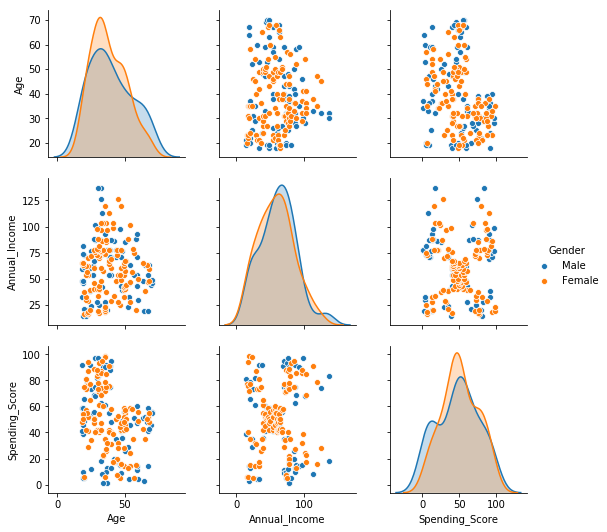

In [4]:
sns.pairplot(df,hue='Gender')

In [6]:
bins = [0,25,35,45,55,65,100]
agegroup = ['Below 25','26 - 35','36 - 45','46 - 55','56 - 65','Above 66']
df['AgeGroup'] = pd.cut(df['Age'],bins=bins,labels=agegroup)
df['GenderGroup'] = df['Gender'].apply(lambda x: 1 if x =='Male' else 0)

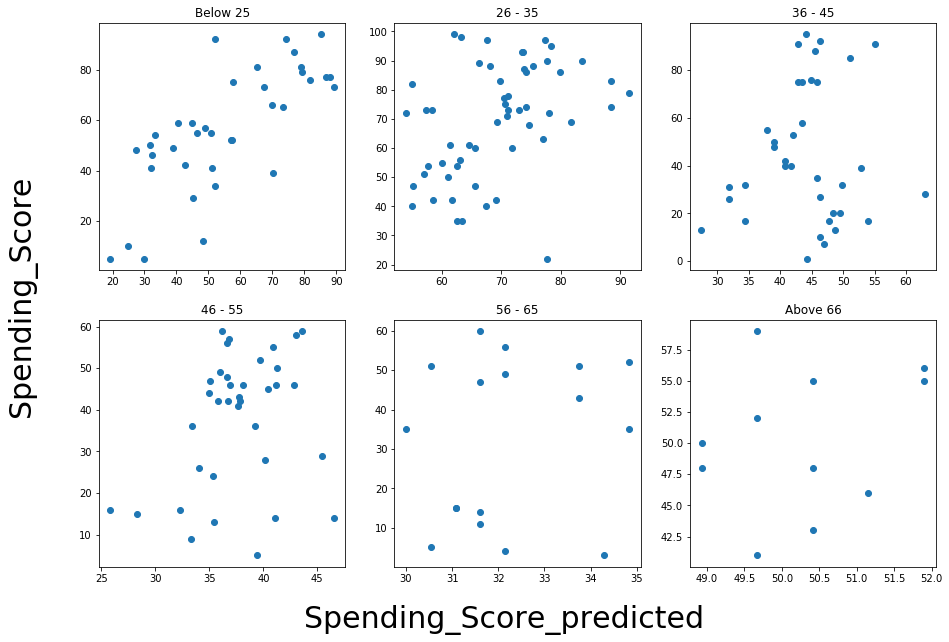

In [58]:
result_Tval = []
result_RS = []
result_para = []
df_orginal = pd.DataFrame()
fig, axs = plt.subplots(2,3,figsize=(15,10))
fig.text(0.5, 0.04, 'Spending_Score_predicted', ha='center',size=30)
fig.text(0.04, 0.5, 'Spending_Score', va='center', rotation='vertical',size=30)
for i in range(0,len(agegroup)):
    df_temp = df[{'Age','Annual_Income','Spending_Score','GenderGroup'}][df['AgeGroup']==agegroup[i]]
    result = forward_selected(df_temp,'Spending_Score')
    result_Tval.append(round(result.pvalues,2))
    result_RS.append(round(result.rsquared_adj,2))
    result_para.append(round(result.params,4))
    df_temp['y_predicted'] = result.predict(df_temp[pd.DataFrame(result.pvalues).index])
    df_temp['residual'] = result.resid
    df_temp['AgeGroup'] = agegroup[i]    
    df_orginal = pd.concat([df_orginal,df_temp])
    if i < 3:
        axs[0][i].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[0][i].set_title(agegroup[i])
    else:
        axs[1][i-3].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[1][i-3].set_title(agegroup[i])        

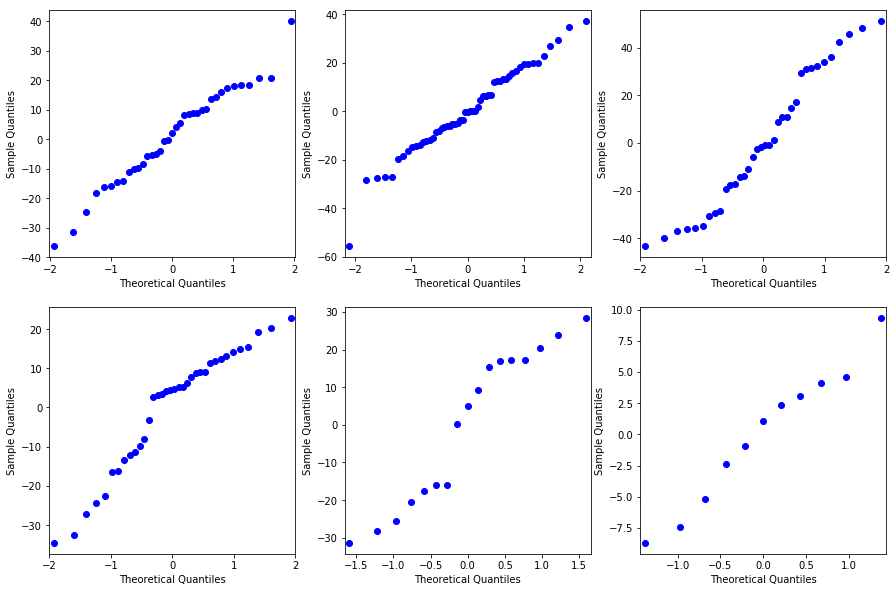

In [59]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(0,len(agegroup)):
    if i < 3:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[0][i])
    else:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[1][i-3]) 